# MCS

_see markdown file for half-baked theory_

Constants:
- $V_n$: coefficient of variation of the expected value of the winning ticket
- $N_{s,min}$: minimum number of samples to estimate the expected value of the number of winning tickets

Procedure is:

1. Determine the set of tickets (size $N_t$) to purchase, $T$, defined by minutes $m$
2. Compute total cost $3\cdot N_t$

For each ticket $i$ in $T$ associated with minute $m_i$:
1. Compute probability of being the winning ticket, $p_i=P[M=m_i=m_w]$
2. Sample $N_w(m_i)$; stop when expected value of samples satisfies the criteria defined above (sample index $j=1,\ldots,N_{s,i}$)
3. Compute the profit from each realization $j$ for minute $i$ as $W\cdot N_{w, j}\cdot p_i$

The samples of $B$ are the collection of all profits computed for the samples of $i$

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tickets import *
from minutes import *
from models import *

In [11]:
counts_2018 = np.genfromtxt('2018_count_250108_0209.csv', delimiter=',', skip_header=1)
day_min_counts = Minutes.day_min(counts_2018[:, 0])
print(f"Loaded {len(counts_2018)} rows of data")
print(f"The shape is {day_min_counts.shape}")

tickets_2018 = np.genfromtxt('2018_tickets_250108_0209.csv', delimiter=',', skip_header=1)
day_min_tickets = Minutes.day_min(tickets_2018)
print(f"Loaded {len(day_min_tickets)} rows of data")
print(f"The shape is {tickets_2018.shape}")
print()
print(f"The mean day is {np.mean(day_min_tickets[:, 0])}")
print(f"The std day is {np.std(day_min_tickets[:, 0])}")
print(f"The mean min is {np.mean(day_min_tickets[:, 1])}")
print(f"The std min is {np.std(day_min_tickets[:, 1])}")

Loaded 31856 rows of data
The shape is (31856, 2)
Loaded 160813 rows of data
The shape is (160813,)

The mean day is 29.77885494331926
The std day is 8.978221476042602
The mean min is 863.0213913054292
The std min is 255.18749935067723


In [12]:
all = Tickets()
all.add([[1, 60]])
day_min_all = Minutes.day_min(all.tickets)

parameters = [np.mean(day_min_tickets[:, 0]),
              np.std(day_min_tickets[:, 0]),
              np.mean(day_min_tickets[:, 1]),
              np.std(day_min_tickets[:, 1])]

transform = Minutes.get_transform(parameters)

day_c, min_c = transform(day_min_counts[:,0], day_min_counts[:,1])
radius_c = Minutes.radius(day_c, min_c)

day_a, min_a = transform(day_min_all[:,0], day_min_all[:,1])
radius_a = Minutes.radius(day_a, min_a)

radius_max = np.max(radius_a)

print(f"Maximum radius is: {radius_max:.3f}")

Maximum radius is: 4.772


In [91]:
def get_band_distribution(minute,
                          radius_c, counts_2018, radius_a, transform,
                          std_increment=0.125):

    day_c, min_c = Minutes.get_day_min(minute[0])
    day_t, min_t = transform(day_c, min_c)
    radius = Minutes.radius(day_t, min_t)
    
    if isinstance(std_increment, list):
        assert len(std_increment) == 2, "std_increment list must have two values"
        radius_min = radius - std_increment[0]
        radius_max = radius + std_increment[1]
    elif isinstance(std_increment, float):
        radius_min = radius - std_increment
        radius_max = radius + std_increment
    else:
        raise ValueError("std_increment must be a list of length 2 or a float")
    
    if radius_min < 0:
        d_radius = radius_max - radius_min
        radius_min = 0
        radius_max = d_radius

    if radius_max > max(radius_a):
        d_radius = radius_max - radius_min
        radius_min = radius_min - d_radius
        radius_max = max(radius_a)
        
    d = evaluate_ticket_dist_i(radius_min, radius_max,
                             radius_c, counts_2018[:, 1],
                             radius_a)
    return d

Minute: 41130


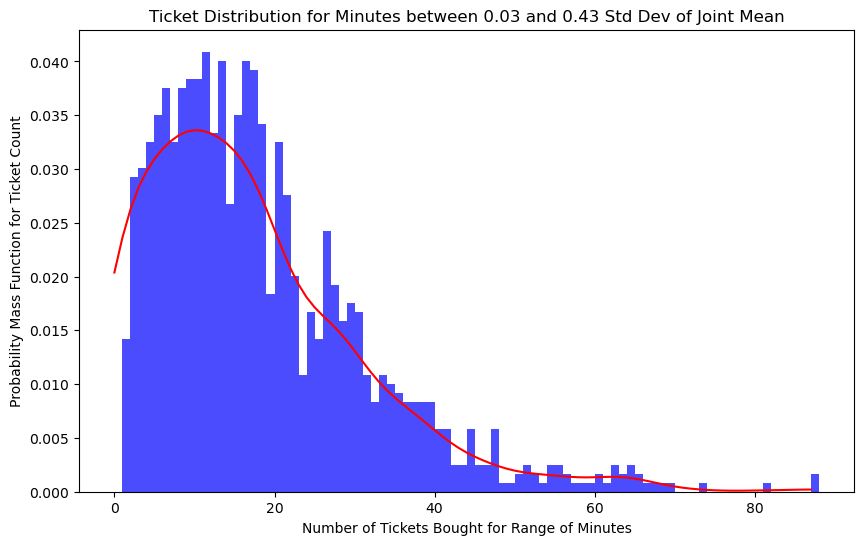

In [92]:
# minute = Minutes.get_minutes([['April'], 25, 13, 10])
minute = Minutes.get_minutes([['April'], 29, 13, 30])
print(f"Minute: {minute[0]}")

d = get_band_distribution(minute,
                          radius_c, counts_2018, radius_a, transform,
                          std_increment=[.2, .2])
d.hist();

In [93]:
minutes = np.arange(0,60*1440).tolist()

dist_all_minutes = []

for minute in minutes:

    dist_all_minutes.append(
        get_band_distribution(
            [minute], radius_c, counts_2018,
            radius_a, transform, std_increment=0.125
            )
            )


In [94]:
with open('pickles/List_of_radial_object_all_minutes.pkl', 'wb') as f:
    pickle.dump(dist_all_minutes, f)

print("RadialDist list saved to 'List_of_radial_object_all_minutes.pkl'")

MemoryError: 